# Dog.. pig.. dog.. pig.. loaf of bread?!?

I started playing with image recognition models recently and it started off very well.  The models I trained were able to easily (and confidently!) identify common pets or objects.  But what about something harder?  I wanted to see it break down so I could see what more training iterations or a large data set would do.  How can I do that easily?

It struck me.  I call it a moment of inspiration.  You might call it lunacy.  Either way, I was amused with the though.

Have you see the movie "The Mitchells vs The Machines"?  The dog Monchi is a pug and for whatever reason causes the dumber robots to explode because they can't figure out if he's a pig, dog, or loaf of bread.  Would this really confuse an AI?

In this blog I will walk through:
* The creation of a Red Hat OpenShift on AWS (ROSA) with Hosted Control Planes (HCP) cluster.
* Installation of Red Hat OpenShift Data Science.
* Creation of a Data Science Project and Workspace.
* Walking through the steps to download image data, train a model, and test if it works.
* And if it doesn't go well for the machines... change things to see if we can get a better result.

The notebook in this blog is based on the excellent [Practical Deep Learning for Coders](https://course.fast.ai/).

Let's get started!

## Create a ROSA HCP Cluster

Follow the documentation on creating a [ROSA with HCP](https://docs.openshift.com/rosa/rosa_hcp/rosa-hcp-sts-creating-a-cluster-quickly.html) cluster.  It is a premier OpenShift cluster supported by Red Hat SRE and is reasonably priced.  

Provision with three (3) `m5.xlarge` workers to make sure the workspace can be deployed successfully.


### Optional: GPU Instance
If you wish to use a GPU, which makes training models much faster, you can:
1. change the instance type for the default workers to `t3.xlarge`
1. reduce worker replicas at creation time to two (2)
1. install one (1) `g5.xlarge` day-2 with:
```bash
rosa create machinepool --cluster=$CLUSTER_NAME --name=gpu --replicas=1 --instance-type=g5.xlarge
```

When setting up the data science workspace you can select "CUDA"!

## Install OpenShift AI
TODO
Looking at a [trial](https://www.redhat.com/en/technologies/cloud-computing/openshift/openshift-ai/trial) setup.

## Access Cluster
Simplest way is to [create an admin user](https://docs.openshift.com/rosa/cloud_experts_tutorials/cloud-experts-getting-started/cloud-experts-getting-started-admin.html).

```bash
rosa create admin --cluster=$CLUSTER_NAME
```

The output of the above command includes the `oc login` statment you can use to login.  This has the username and password you'll need later.

In [1]:
#hidden
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")


In [2]:
!pip install -Uqq fastai duckduckgo_search

In [3]:
from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')    

In [24]:
from fastdownload import download_url
from fastai.vision.all import *

def download_validation_image(term):
    urls = search_images(f"{term} photos", max_images=1)

    dest = f"validation_data/{term}.jpg"
    download_url(urls[0], dest, show_progress=False)

    im = Image.open(dest)
    return im.to_thumb(256,256)

Searching for 'pug face photos'


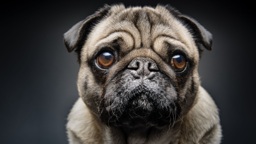

In [32]:
download_validation_image("pug face")

Searching for 'cute pug face photos'


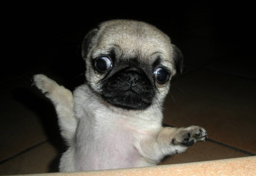

In [33]:
download_validation_image("cute pug face")

Searching for 'pug full body adult photos'


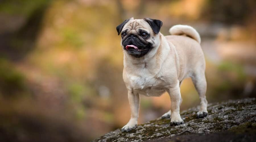

In [34]:
download_validation_image("pug full body adult")

Searching for 'pig photos'


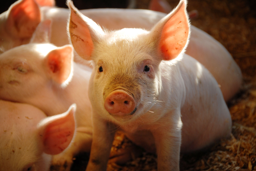

In [35]:
download_validation_image("pig")

Searching for 'bread photos'


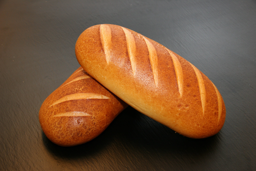

In [36]:
download_validation_image("bread")

In [31]:
searches = ['dog','pig','loaf of bread']
path = Path('training_data/mvm')
from time import sleep

max_images=5

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'"{o}" photo', max_images))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'"{o} in sun" photo', max_images))
    sleep(10)
    download_images(dest, urls=search_images(f'"{o} in shade" photo', max_images))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for '"dog" photo'
Searching for '"dog in sun" photo'
Searching for '"dog in shade" photo'
Searching for '"pig" photo'
Searching for '"pig in sun" photo'
Searching for '"pig in shade" photo'
Searching for '"loaf of bread" photo'
Searching for '"loaf of bread in sun" photo'
Searching for '"loaf of bread in shade" photo'


In [37]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

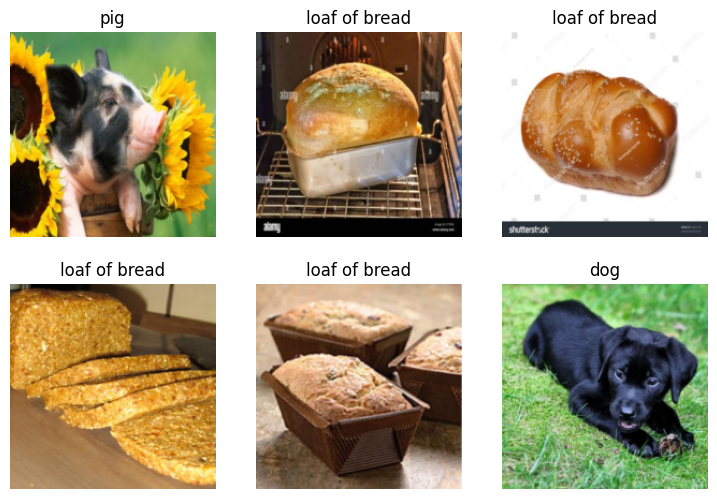

In [45]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [46]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.564938,0.283498,0.099071,01:57


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

This is a: loaf of bread (1).
Probability it's a loaf of bread: 0.5770


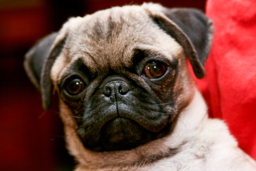

In [172]:
def check_category(term):
    category,category_num,probs = learn.predict(PILImage.create(f"{term}.jpg"))
    print(f"This is a: {category}")
    print(f"Probability it's a {category}: {probs[category_num]:.4f}")
    im = Image.open(dest)
    return im.to_thumb(256,256)

This is a: dog (0).
Probability it's a dog: 0.7470


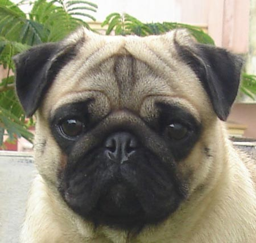

In [173]:
check_category("cute pug face")

This is a: dog (0).
Probability it's a dog: 0.9579


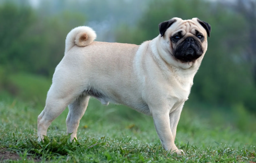

In [174]:
check_category("pug full body adult")

This is a: dog (0).
Probability it's a dog: 0.6427


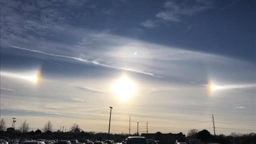

In [175]:
check_category("pig")

This is a: loaf of bread (1).
Probability it's a loaf of bread: 1.0000


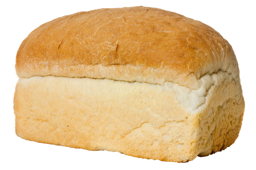

In [179]:
check_category("bread")

It's accurate enough it seems.  But if needed, can train with more epochs and/or more image data.

**NOTE**: if 'sun dog' is not a known category, it will be a hit for dog images.  I guess there's some 'sun dog' data getting into the data?

# Revision: sun dog
Add category for 'sun dog' and retrain the model.

In [181]:
# larger data set.. does it get better? (answer:yes)
o='sun dog'
dest = (path/o)
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=search_images(f'"{o}" photo', max_images*3)) # do not get 'sun' and 'shade' variants
sleep(10)  # Pause between searches to avoid over-loading server
resize_images(path/o, max_size=400, dest=path/o)

Searching for '"sun dog" photo'


In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

In [182]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.100838,0.195588,0.100000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.314570,0.055110,0.020000,00:08
1,0.186981,0.064323,0.020000,00:08
2,0.131901,0.067112,0.020000,00:08


This is a: pig (2).
Probability it's a pig: 0.7142


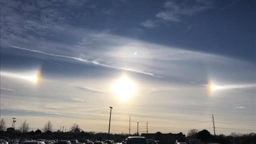

In [183]:
dest='sun-dog.jpg'
category,category_num,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {category} ({category_num}).")
print(f"Probability it's a {category}: {probs[category_num]:.4f}")
im = Image.open(dest)
im.to_thumb(256,256)

# Revision: train more!

In [184]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.639812,0.253418,0.080000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.251201,0.165717,0.040000,00:08
1,0.190811,0.072509,0.020000,00:08
2,0.159809,0.064339,0.020000,00:08
3,0.123704,0.078428,0.020000,00:08
4,0.096000,0.079601,0.040000,00:08
5,0.075531,0.072987,0.040000,00:08
6,0.062239,0.058037,0.040000,00:08
7,0.057251,0.046941,0.040000,00:08
8,0.048383,0.045391,0.020000,00:08
9,0.041824,0.046466,0.020000,00:08


This is a: dog (0).
Probability it's a dog: 0.9979


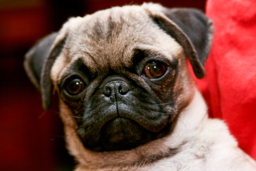

In [185]:
dest='pug.jpg'
category,category_num,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {category} ({category_num}).")
print(f"Probability it's a {category}: {probs[category_num]:.4f}")
im = Image.open(dest)
im.to_thumb(256,256)

This is a: pig (2).
Probability it's a pig: 0.5717


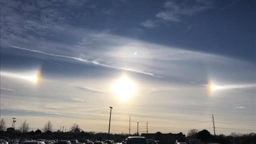

In [186]:
dest='sun-dog.jpg'
category,category_num,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {category} ({category_num}).")
print(f"Probability it's a {category}: {probs[category_num]:.4f}")
im = Image.open(dest)
im.to_thumb(256,256)

# Revision: more data!!

In [188]:
# only more data for dog, pig, and loaf of bread
searches = ['dog','pig','loaf of bread']

max_images = max_images * 3

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'"{o}" photo', max_images))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'"{o} in sun" photo', max_images))
    sleep(10)
    download_images(dest, urls=search_images(f'"{o} in shade" photo', max_images))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for '"dog" photo'
Searching for '"dog in sun" photo'
Searching for '"dog in shade" photo'


/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for '"pig" photo'
Searching for '"pig in sun" photo'
Searching for '"pig in shade" photo'


/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparen

Searching for '"loaf of bread" photo'
Searching for '"loaf of bread in sun" photo'
Searching for '"loaf of bread in shade" photo'


/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/app-root/lib64/py

In [202]:
# more sun dog
o='sun dog'
dest = (path/o)
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=search_images(f'"{o}" photo', max_images*9)) # do not get 'sun' and 'shade' variants
sleep(10)  # Pause between searches to avoid over-loading server
resize_images(path/o, max_size=400, dest=path/o)

Searching for '"sun dog" photo'


In [203]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

In [204]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.075770,0.189171,0.060000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.286544,0.100705,0.060000,00:08
1,0.198508,0.063818,0.020000,00:09
2,0.165498,0.052129,0.020000,00:08
3,0.143519,0.048872,0.020000,00:08
4,0.112405,0.045015,0.020000,00:08
5,0.088398,0.032112,0.020000,00:08
6,0.073769,0.020308,0.020000,00:08
7,0.060392,0.017364,0.020000,00:08
8,0.050124,0.014712,0.000000,00:09
9,0.042717,0.019643,0.020000,00:08


This is a: pig (2).
Probability it's a pig: 0.6431


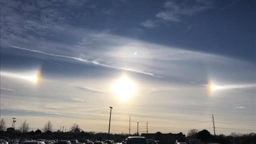

In [205]:
dest='sun-dog.jpg'
category,category_num,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {category} ({category_num}).")
print(f"Probability it's a {category}: {probs[category_num]:.4f}")
im = Image.open(dest)
im.to_thumb(256,256)